In [242]:
#This Notebook presents a code to do a decompositon onto Alfven Slow and Fast modes
#Darryl Seligman version3 9/11/18
#Adapted from version of code by Jonathan Squire
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import *
import sys
sys.path.append('/Users/darrylseligman/Desktop/Flatiron/Phil/Initial_Magnetic_Simulations/PFH_python/pfh_python')
from get_particle_hsml_ngb import *
from grain_density_from_snapshot import *
from example_plotting_routine import *
def mode_decomp(Vx,Vy,Vz,beta):
    #Form grid of K
    n=Vx.shape[0]
    
    N=[n,n,n]
    L=[1.,1.,1.]
    if(n%2==0):
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1,N[0]/2)
    else:
        print "hello"
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1.5,N[0]/2)
        bb=np.append(bb,[.5])
    #Form k-space vectors for each dimension [0 1 2 3 ... N/2-1 -N/2 -N/2+1 ... -2 -1]*2*pi/L
    
    kx=  2*np.pi*1j/L[0]*np.concatenate((b,bb))
    ky=  2*np.pi*1j/L[1]*np.concatenate((b,bb))
    kz=  2*np.pi*1j/L[2]*np.concatenate((b,bb))
   
    #print kx.shape
    #xg=np.linspace(0.,1.,n)
    #yg=np.linspace(0.,1.,n)
    #zg=np.linspace(0.,1.,n)
    #x,y,az=np.meshgrid(xg,yg,zg,indexing='ij')
    #3D arrays of k-space grid
    KX,KY,KZ= np.meshgrid(kx,ky,kz)#,indexing='ij')
    #grid of |K|, kperp (B0 is in x direction) and k_hat
    Kmag = np.sqrt(abs(KX**2+KY**2+KZ**2))
    Kperp = np.sqrt(abs(KY**2+KX**2))
    #Kmag[0]=1.
    khx = KX/Kmag;
    khy = KY/Kmag;
    khz = KZ/Kmag;
    khx[np.isnan(khx)]=0.
    khy[np.isnan(khy)]=0.
    khz[np.isnan(khz)]=0.
    #k-Grid for binning the spectra
    kgrid = np.arange(0,max(ky.imag)+2.*np.pi/L[0],2.*np.pi/L[0])

    kgridG = (kgrid[0:kgrid.size-1] +  kgrid[1:kgrid.size])/2;   
    #Get B and V, take fourier transforms  
    fVx = fftn(Vx);
    fVy = fftn(Vy); 
    fVz = fftn(Vz);
    # % Alfvenic part -- part of B and u in k*b_hat direction                                                                                                                                                                      
    #% b_hat is x direction 
    kcbhz = 0;
    kcbhy = (khx);
    kcbhx =  - (khy);
    #Alfvenic part of V, (k*bh).V 
    alfV =  kcbhy*fVy + kcbhx*fVx;
    
    #% Now decompose compressive part into fast and slow                                                                                                                                                                          
    #% I think this is right, but never actually used this seriously  
    
    costh = abs(khz);
    sinth = np.sqrt(1.-costh**2);
    Kperp[Kperp==0]=1.;
    #for strong beta regime A33 - A34
    if(beta>1.e2):
        thx = -sinth*np.sign(KX);
        #thx = sinth*khx;
        Kperp[Kperp==0]=1.;
        thy = costh*(KY/Kperp);
        thz = costh*(KZ/Kperp);
        #% Slow wave part  
        slowV = -thx*fVx - thy*fVy - thz*fVz + costh*sinth/beta*(khx*fVx + khy*fVy + khz*fVz);
        #% Fast wave part  
        fastV = costh*sinth/beta*(thx*fVx + thy*fVy + thz*fVz) + khx*fVx + khy*fVy + khz*fVz;
    #General beta case A29 - A30
    elif(beta<10.):
        alpha = beta/2.
        slowV = (khz*fVz)-costh*sinth*alpha*((khy)*fVy + (khx)*fVx)
        fastV = costh*sinth*alpha*(khz*fVz)-((khy)*fVy + (khx)*fVx)


       
        
    else:
        alpha = beta/2.
        D = np.array(((1.+alpha)**2-4.*alpha*costh*costh),dtype=complex)
        #normalize
        fz = np.sum(abs(khz*fVz))
        fxy = np.sum(abs((khy)*fVy + (khx)*fVx))
        fracz = fz/(fz+fxy)
        fracxy=fxy/(fz+fxy)
        slowV = ((-1.+alpha-np.sqrt(D))*(khz*fVz)+(1.+alpha-np.sqrt(D))*((khy)*fVy + (khx)*fVx))/((-1.+alpha-np.sqrt(D))*fracz+(1.+alpha-np.sqrt(D))*fracxy)
        slowV[np.isnan(slowV)]=0.
        fastV= ((-1.+alpha+np.sqrt(D))*(khz*fVz)+(1.+alpha+np.sqrt(D))*((khy)*fVy + (khx)*fVx))/((-1.+alpha+np.sqrt(D))*fracz+(1.+alpha+np.sqrt(D))*fracxy)

        
        
    alfVIso = spect1D((alfV),Kmag,kgrid)
    #VIso = spect1D(fVx,Kmag,kgrid) + spect1D(fVy,Kmag,kgrid) + spect1D(fVz,Kmag,kgrid); #% velocity spectrum
    #SpFIso =spect1D(cmpVx,Kmag,kgrid) + spect1D(cmpVy,Kmag,kgrid) + spect1D(cmpVz,Kmag,kgrid); #% Compressive part (slow+fast) of the velocity
    slowVIso = spect1D((slowV),Kmag,kgrid); #% Slow mode part
    fastVIso = spect1D((fastV),Kmag,kgrid); #% Fast mode part
    #VIso1 = spect1D((thetapart),Kmag,kgrid)
    #VIso2 = spect1D((khatpart),Kmag,kgrid)
    return(kgridG,alfVIso,fastVIso,slowVIso)
def spect1D(v1,K,kgrid):
    # % Function to find the spectrum <v1^2>,
    #% K is the kgrid associated with v1
    #% kgrid is the grid for spectral shell binning
    nk = len(kgrid)-1;
    print nk
    out1 = np.zeros((nk))
    NT2 = K.size**2;
    for kk in np.arange(nk):

        out1[kk]= np.sum(abs(v1[(K<=kgrid[kk+1]) & (K>=kgrid[kk])])**2 )/NT2;

    return out1    

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63


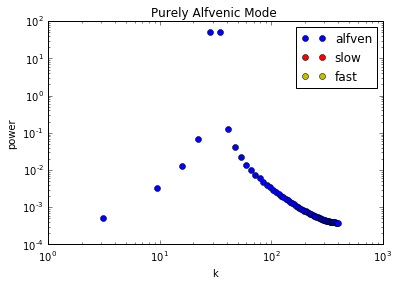

In [262]:
#Test for a linear purely Alfvenic Mode
#can experimenet with changing beta
beta=1.;
#experiment with changing NN - changes peak of power
NN=5.
n=128
xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')
Vx = np.zeros((n,n,n))
Vz = np.zeros((n,n,n))#+.01*np.random.rand(n,n,n)

Vy = 10.1*np.sin(2.*NN*np.pi*x)

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
#plt.loglog(kgridG,viso,'ko',label='viso')
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Purely Alfvenic Mode ')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63
[  1.71121856e-03   1.88826966e-02   5.05286384e+01   5.05501813e+01
   5.00476387e-02   1.70352628e-02   9.23517259e-03   5.97673333e-03
   4.25211490e-03   3.21058193e-03   2.52598986e-03   2.04857859e-03
   1.70074068e-03   1.43859669e-03   1.23564525e-03   1.07503048e-03
   9.45574488e-04   8.39605317e-04   7.51703128e-04   6.77943824e-04
   6.15425411e-04   5.61961763e-04   5.15879051e-04   4.75877094e-04
   4.40932863e-04   4.10232043e-04   3.83119640e-04   3.59063784e-04
   3.37628836e-04   3.18455136e-04   3.01243583e-04   2.85743769e-04
   2.71744748e-04   2.59067802e-04   2.47560709e-04   2.37093181e-04
   2.27553189e-04   2.18844003e-04   2.10881773e-04   2.03593552e-04
   1.96915666e-04   1.90792370e-04   1.85174724e-04   1.80019655e-04
   1.75289174e-04   1.70949712e-04   1.66971557e-04   1.63328383e-04
   1.59996845e-04   1.56956230e-04   1.54188167e-04   1.51676371e-04
   1.49406429e-04   1.47365611e-04   1.45542712e-04   1.43927918e-04
   1.42512685e-04   1.412

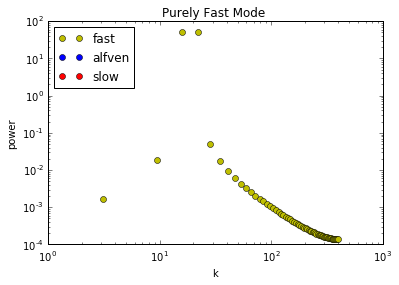

In [263]:
#test just a fast wave 
# Frank Shu Gas Dynamics page 307 example b - k perp to B_0 - then the slow velocity is zero
beta=1.;
#units alfven speed = 1
NN = 3.

xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')

xpart=1.#.01
zpart=np.sqrt(1.-xpart**2)
Vy = np.zeros((n,n,n))
Vz =np.zeros((n,n,n))
Vx = 10.1*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))



kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')

#plt.yscale('log')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('power')
plt.title('Purely Fast Mode ')
print fastVIso

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63
[  1.67750080e-03   1.85106329e-02   4.95330246e+01   4.95541430e+01
   4.90615025e-02   1.66996009e-02   9.05320320e-03   5.85896807e-03
   4.16833144e-03   3.14732079e-03   2.47621788e-03   2.00821350e-03
   1.66722937e-03   1.41025065e-03   1.21129815e-03   1.05384813e-03
   9.26942935e-04   8.23061775e-04   7.36891607e-04   6.64585653e-04
   6.03299099e-04   5.50888896e-04   5.05714196e-04   4.66500435e-04
   4.32244744e-04   4.02148852e-04   3.75570669e-04   3.51988809e-04
   3.30976214e-04   3.12180312e-04   2.95307894e-04   2.80113488e-04
   2.66390303e-04   2.53963143e-04   2.42682785e-04   2.32421508e-04
   2.23069492e-04   2.14531912e-04   2.06726569e-04   1.99581955e-04
   1.93035649e-04   1.87033007e-04   1.81526050e-04   1.76472557e-04
   1.71835285e-04   1.67581327e-04   1.63681557e-04   1.60110169e-04
   1.56844275e-04   1.53863572e-04   1.51150051e-04   1.48687747e-04
   1.46462532e-04   1.44461926e-04   1.42674946e-04   1.41091970e-04
   1.39704622e-04   1.385

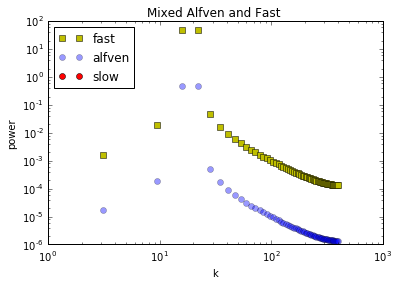

In [264]:
#Mixed Alfven and Fast Test - so we know that the ratios are correct

beta=1.;
#units alfven speed = 1
NN = 3.

xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')

xpart=1.#.01
zpart=np.sqrt(1.-xpart**2)

Vz =np.zeros((n,n,n))
Vy = 1.*np.sin(2.*NN*np.pi*x)
Vx = 10.*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))



kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.loglog(kgridG,fastVIso,'ys',label='fast')
plt.loglog(kgridG,alfVIso,'bo',label='alfven',alpha=.4)
plt.loglog(kgridG,slowVIso,'ro',label='slow')

#plt.yscale('log')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('power')
plt.title('Mixed Alfven and Fast ')
print fastVIso

In [265]:
print fastVIso/alfVIso


[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63


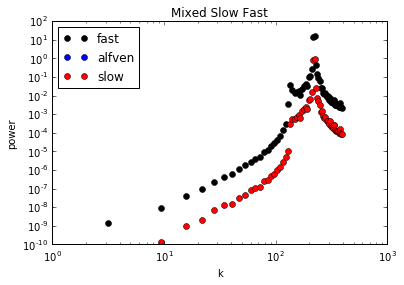

In [266]:
#now test a slow mode and fast mode
beta=1.;
#units alfven speed = 1
NN = 35.

xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')

xpart=.6#.01
zpart=np.sqrt(1.-xpart**2)
Vy = np.zeros((n,n,n))
Vz =np.zeros((n,n,n))
Vx = 10.1*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))


kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.loglog(kgridG,fastVIso,'ko',label='fast')
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')

#plt.yscale('log')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('power')
plt.title('Mixed Slow Fast')

0.541196100146
1.30656296488


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63
[  5.82842712   6.52995628   7.03765879   8.19463167  15.1141135
  20.0170947   14.50743319  10.93515905   8.5425579    7.18775388
   6.76664701   6.43657545   6.30906708   6.1362542    6.04884577
   5.98091787   5.93369765   5.89606569   5.8721161    5.8485989
   5.83138832   5.82151508   5.80992507   5.80289497   5.79914508
   5.79502282   5.79052987   5.78790931   5.78651208   5.78579482
   5.78466317   5.78440098   5.78395787   5.78411814   5.78431524
   5.78453916   5.78501572   5.7854982    5.7860415    5.78663678
   5.78721224   5.78782103   5.78862103   5.78921773   5.78994897
   5.79072157   5.79132626   5.79203197   5.79264977   5.79323827
   5.7937095    5.79454447   5.79529645   5.79578046   5.7964474
   5.79684531   5.7975711    5.79798173   5.79860549   5.79907401
   5.79940957   5.80007215   5.80052308]



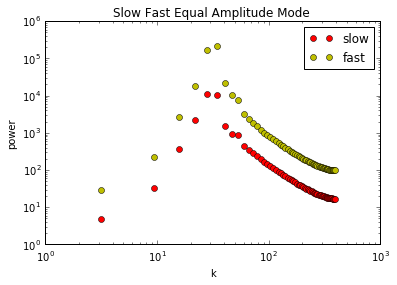

In [287]:
# new mixed slow fast mode test based on Jono's notes
beta=1.;
NN=5.
n=128
xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)

theta = np.pi/4.

k = 2.*np.pi*NN
kx = 2.*np.pi*NN*np.sin(theta)
kz = 2.*np.pi*NN*np.cos(theta)

#1/beta
b0= 1./beta
vs = np.sqrt(.5*(1.+b0**2-((1.+b0**2)**2-4.*b0**2*kz**2/k**2)**.5))
vf = np.sqrt(.5*(1.+b0**2+((1.+b0**2)**2-4.*b0**2*kz**2/k**2)**.5))
print vs
print vf
#fast wave
Vx = -kx*k*vf*np.sin(kx*x+kz*z)
Vz = -vf*k/kz*(-kz**2+k**2*vs**2)*np.sin(kx*x+kz*z)

#slow wave
Vx += -kx*k*vs*np.sin(kx*x+kz*z)
Vz += -vs*k/kz*(-kz**2+k**2*vf**2)*np.sin(kx*x+kz*z)

Vy = np.zeros((n,n,n))

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)

print fastVIso/slowVIso
print 

plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Slow Fast Equal Amplitude Mode ')
plt.savefig('slowfast_equal.pdf')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63
[ 0.28776075  0.26448851  0.25113775  0.22521089  0.15286855  0.13132578
  0.15638314  0.18549695  0.21790298  0.24562883  0.2563991   0.26580862
  0.26973902  0.27533582  0.27832499  0.28072438  0.28244739  0.28385888
  0.28477966  0.28571257  0.2864081   0.28682967  0.2873208   0.28763724
  0.28782108  0.2880215   0.28824534  0.2883882   0.28848026  0.28854245
  0.2886232   0.28866403  0.28871209  0.2887376   0.28875708  0.28877824
  0.2887813   0.28878996  0.28878689  0.28878689  0.288785    0.28877853
  0.28876882  0.28876104  0.28875044  0.28873798  0.28872778  0.28871523
  0.28870394  0.28869307  0.28868466  0.28866708  0.28865114  0.2886413
  0.2886268   0.28861882  0.2886023   0.28859368  0.28857926  0.2885688
  0.28856181  0.28854585  0.28853541]



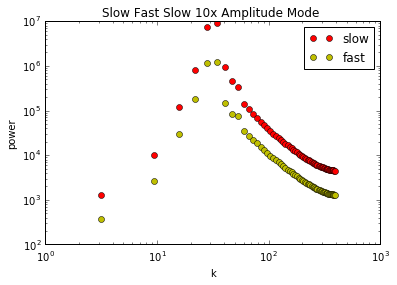

In [286]:
#same thing as above but changing amplitude in the modes

#fast wave
Vx = -kx*k*vf*np.sin(kx*x+kz*z)
Vz = -vf*k/kz*(-kz**2+k**2*vs**2)*np.sin(kx*x+kz*z)

#slow wave
Vx += -10.*kx*k*vs*np.sin(kx*x+kz*z)
Vz += -10.*vs*k/kz*(-kz**2+k**2*vf**2)*np.sin(kx*x+kz*z)

Vy = np.zeros((n,n,n))

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)

print fastVIso/slowVIso
print 

plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Slow Fast Slow 10x Amplitude Mode ')
plt.savefig('slowfast_10x.pdf')

Keys: [u'Desired_Number_Of_Neighbors', u'Mass_Density_List_Of_Gas_NeighborsVX', u'Mass_Density_List_Of_Gas_NeighborsVY', u'Mass_Density_List_Of_Gas_NeighborsVZ', u'Minimum_Smoothing_Length_Allowed', u'Number_Of_Simulation_Dimensions', u'Periodic_BoxSize', u'Smoothing_Length_List_Of_Gas_NeighborsVX', u'Smoothing_Length_List_Of_Gas_NeighborsVY', u'Smoothing_Length_List_Of_Gas_NeighborsVZ', u'Snapshot_Directory', u'Snapshot_Number', u'Snapshot_Time', u'Total_Number_Of_Dust_Particles', u'Total_Number_Of_Gas_Particles', u'x_grid', u'y_grid', u'z_grid']
hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


62
62
62


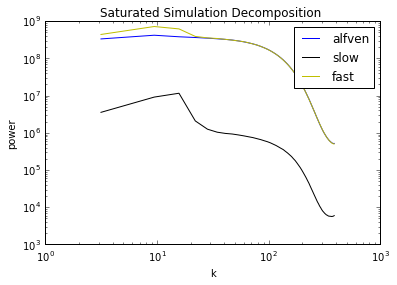

In [267]:
#now run the code on our simulation
infi=h5py.File('/Users/darrylseligman/Desktop/Flatiron/Phil/Initial_Magnetic_Simulations/jono_default_params/b0_N64/output_wheeler/dust_ALFVEN_snap_0946.h5','r') # (defined same as above) 
print("Keys: %s" % infi.keys())
#h_g = np.array(infi["Smoothing_Length_List_Of_Gas_Neighbors"]) # this will act like a normal vector: h_g[:] for all elements
#h_d=np.array(infi["Smoothing_Length_List_Of_Dust_Neighbors"])
#read the list of B and V
#B0=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B0"])
#B1=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B1"])
#B2=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B2"])

V0=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVX"])
V1=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVY"])
V2=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVZ"])
xgrid=np.array(infi["x_grid"])
#nngb_d_v1=np.array(infi["Mass_Density_List_Of_Dust_Neighbors_v1"])
#nngb_g_v1=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_v1"])

infi.close() 

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(V0,V1,V2,1.)

plt.loglog(kgridG,alfVIso,'b',label='alfven')
plt.loglog(kgridG,slowVIso,'k',label='slow')
plt.loglog(kgridG,fastVIso,'y',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Saturated Simulation Decomposition ')

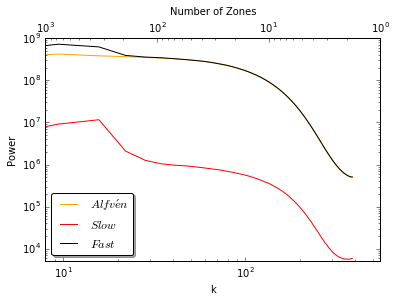

In [268]:
fig, ax1 = plt.subplots()
#kvec=(np.arange(len(kgridG))+1)*2.*np.pi
#kvec2=np.arange(512+5)#*2.*np.pi
#print kvec2

ax1.loglog(kgridG,alfVIso,label=r'$Alfv\'en$',color='orange',alpha=1.)
ax1.loglog(kgridG,slowVIso,'r',label=r'$Slow$')
ax1.loglog(kgridG,fastVIso,'k',label=r'$Fast$')

ax1.set_xlim([8.,550])
ax2=ax1.twiny()
ax2.loglog(kgridG/(np.pi),np.zeros_like(kgridG))
ax2.set_xlim(ax2.get_xlim()[::-1])
#ax2.set_xlim(512.,1.)
#print ax2.get_xlim()[::-1]
ax2.set_xlabel('Number of Zones',fontsize=10)
ax1.set_xlabel('k',fontsize=10)
ax1.set_ylabel('Power',fontsize=10)
ax1.set_ylim([5.e3,1.e9])
ax1.legend(fancybox=True, shadow=True,loc='lower left')
plt.savefig('Saturated_64x64x64_decomposition.pdf')
#plt.ylabel('Power')